<font size="5">ChronoNet Implementation</font>

In this notebook a ChronoNet implementation is trained with 5-fold cross-validation. Due to memory constraints, the process is not in a closed loop, but rather in different cells and executed one after the other.

In [1]:
# Import modules and dependencies

import os
from os import listdir
from os.path import isdir, join
import pathlib

import random
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

import pandas as pd


import akida
from akida import FullyConnected
from akida import evaluate_sparsity
import cnn2snn
from cnn2snn import check_model_compatibility
from cnn2snn import quantize
from cnn2snn import quantize_layer
from cnn2snn import convert

from keras import Model, regularizers
from tensorflow.keras import Input
from tensorflow.keras.layers import (Reshape, Activation, Flatten, Rescaling, Add, Dropout, AveragePooling2D, MaxPooling2D, Softmax)

import akida_models
from akida_models import layer_blocks
from akida_models.layer_blocks import conv_block, separable_conv_block, dense_block

from sklearn.model_selection import KFold


from math import ceil
import pickle

In [2]:
# If needed, set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Loading preprocessed Data

feature_sets_path = '/home/sebastian/Schreibtisch/Masterarbeit/EEG/'
feature_sets_file_data = 'raw_eeg_22channels_60smaxpersubj_Zscore_nosplit_normcast_floatdata_copy.sav'
feature_sets_file_label = 'raw_eeg_22channels_60smaxpersubj_Zscore_nosplit_normcast_floatlabel_copy.sav'

CNN_model_filename = 'CNN_model_raw_eeg.h5'
Quantized_model_filename = 'quantized_model_raw_eeg.h5'
Akida_model_filename = 'akida_model_raw_eeg.h5'

CNN0_model_filename = 'ChronoNet0_model_raw_eeg.h5'
CNN1_model_filename = 'ChronoNet1_model_raw_eeg.h5'
CNN2_model_filename = 'ChronoNet2_model_raw_eeg.h5'
CNN3_model_filename = 'ChronoNet3_model_raw_eeg.h5'
CNN4_model_filename = 'ChronoNet4_model_raw_eeg.h5'

In [4]:
# Load data as memory mapping

x_data = np.load(feature_sets_file_data, mmap_mode='r', allow_pickle=True)
y_data = np.load(feature_sets_file_label, mmap_mode='r', allow_pickle=True)

In [5]:
# Define the input shape

input_shape = x_data[2990].shape
print('Input shape of model is: ', input_shape)

Input shape of model is:  (22, 15000)


In [6]:
print('Number of labels: ', len(y_data))
print('Number of EEG_data: ', len(x_data))
num_labels = 2
print('Number of classes: ', num_labels)

Number of labels:  2993
Number of EEG_data:  2993
Number of classes:  2


In [7]:
# Define a batch generator for training

class EEG_Mem_Generator(keras.utils.Sequence) :
  
  def __init__(self, x_data, y_data, batch_size) :
    self.x_data = x_data
    self.y_data = y_data
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.x_data) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.x_data[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.y_data[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array(batch_x), np.array(batch_y)

<font size="5">Fold Number 1</font>

In [8]:
# Define the data for the first fold

batch_size = 64

training_data_batch = EEG_Mem_Generator(x_data[598:2993], y_data[598:2993], batch_size)
val_data_batch = EEG_Mem_Generator(x_data[:598], y_data[:598], batch_size)

In [9]:
# Define the ChronoNet model

inputs = Input(shape=input_shape)
x = tf.transpose(inputs, perm = [0,2,1])


x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.GRU(32,return_sequences=True)(x)
x2 = tf.keras.layers.GRU(32,return_sequences=True)(x1)

x_con1 = tf.concat([x1,x2], axis = -1)

x3 = tf.keras.layers.GRU(32,return_sequences=True)(x_con1)

x_con2 = tf.concat([x1,x2,x3], axis = -1)

x = tf.keras.layers.GRU(32,return_sequences=False)(x_con2)

outputs = tf.keras.layers.Dense(units = 2,activation = 'softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

2022-04-25 18:01:20.232023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 18:01:20.442546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 18:01:20.443346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 18:01:20.447359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "CNN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 15000, 22)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 7500, 32)     2848        tf.compat.v1.transpose[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7500, 32)     1440        tf.compat.v1.transpose[0][0]     
__________________________________________________________________________________________

In [10]:
# Compile the model

CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
history = CNN_model.fit_generator(generator=training_data_batch,
                   steps_per_epoch = int(2395 // batch_size),
                   epochs = 500,
                   validation_data = val_data_batch,
                   validation_steps = int(598 // batch_size))

/home/sebastian/anaconda3/envs/akida_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-25 18:01:22.949746: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 18:01:23.041157: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-25 18:01:26.346776: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 18:01:26.495748: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 18:01:28.881665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-04-25 18:01:31.556898: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-25 18:01:32.344285: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 2/37 [>.............................] - ETA: 7s - loss: 0.8813 - accuracy: 0.4219  

2022-04-25 18:01:33.894618: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 35640000 exceeds 10% of free system memory.
2022-04-25 18:01:34.169040: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.


37/37 [==============================] - 21s 276ms/step - loss: 0.6958 - accuracy: 0.5663 - val_loss: 0.6538 - val_accuracy: 0.6267
Epoch 2/500
37/37 [==============================] - 9s 244ms/step - loss: 0.6623 - accuracy: 0.6010 - val_loss: 0.6750 - val_accuracy: 0.6042
Epoch 3/500
37/37 [==============================] - 9s 244ms/step - loss: 0.6464 - accuracy: 0.6216 - val_loss: 0.6641 - val_accuracy: 0.5955
Epoch 4/500
37/37 [==============================] - 9s 245ms/step - loss: 0.6154 - accuracy: 0.6662 - val_loss: 0.6069 - val_accuracy: 0.6736
Epoch 5/500
37/37 [==============================] - 9s 245ms/step - loss: 0.6022 - accuracy: 0.6800 - val_loss: 0.6047 - val_accuracy: 0.6684
Epoch 6/500
37/37 [==============================] - 9s 244ms/step - loss: 0.5702 - accuracy: 0.7091 - val_loss: 0.5878 - val_accuracy: 0.6927
Epoch 7/500
37/37 [==============================] - 9s 245ms/step - loss: 0.5475 - accuracy: 0.7207 - val_loss: 0.5729 - val_accuracy: 0.7031
Epoch 8/50

37/37 [==============================] - 9s 244ms/step - loss: 0.2871 - accuracy: 0.8752 - val_loss: 0.6492 - val_accuracy: 0.7413
Epoch 59/500
37/37 [==============================] - 9s 242ms/step - loss: 0.2379 - accuracy: 0.9052 - val_loss: 0.7454 - val_accuracy: 0.7083
Epoch 60/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2164 - accuracy: 0.9056 - val_loss: 0.6954 - val_accuracy: 0.7500
Epoch 61/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1866 - accuracy: 0.9224 - val_loss: 0.7770 - val_accuracy: 0.7483
Epoch 62/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1826 - accuracy: 0.9219 - val_loss: 0.7643 - val_accuracy: 0.7396
Epoch 63/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1772 - accuracy: 0.9271 - val_loss: 0.8615 - val_accuracy: 0.7292
Epoch 64/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1869 - accuracy: 0.9266 - val_loss: 0.7794 - val_accuracy: 0.7309
Epoch

Epoch 115/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1381 - accuracy: 0.9481 - val_loss: 0.9742 - val_accuracy: 0.7274
Epoch 116/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1090 - accuracy: 0.9592 - val_loss: 1.0719 - val_accuracy: 0.7309
Epoch 117/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0853 - accuracy: 0.9661 - val_loss: 1.0319 - val_accuracy: 0.7483
Epoch 118/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1027 - accuracy: 0.9575 - val_loss: 1.0001 - val_accuracy: 0.7378
Epoch 119/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1344 - accuracy: 0.9472 - val_loss: 0.9348 - val_accuracy: 0.7274
Epoch 120/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1122 - accuracy: 0.9588 - val_loss: 1.0757 - val_accuracy: 0.7587
Epoch 121/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1034 - accuracy: 0.9588 - val_loss: 1.0574 - val_ac

37/37 [==============================] - 9s 244ms/step - loss: 0.0988 - accuracy: 0.9620 - val_loss: 1.1338 - val_accuracy: 0.7066
Epoch 228/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0990 - accuracy: 0.9605 - val_loss: 1.0784 - val_accuracy: 0.7240
Epoch 229/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1418 - accuracy: 0.9447 - val_loss: 1.0120 - val_accuracy: 0.6962
Epoch 230/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1491 - accuracy: 0.9395 - val_loss: 0.8437 - val_accuracy: 0.7292
Epoch 231/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0938 - accuracy: 0.9674 - val_loss: 1.0998 - val_accuracy: 0.7205
Epoch 232/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0644 - accuracy: 0.9768 - val_loss: 1.1246 - val_accuracy: 0.7118
Epoch 233/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0753 - accuracy: 0.9678 - val_loss: 1.1979 - val_accuracy: 0.7188

37/37 [==============================] - 9s 243ms/step - loss: 0.0727 - accuracy: 0.9721 - val_loss: 1.2056 - val_accuracy: 0.7274
Epoch 340/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0527 - accuracy: 0.9837 - val_loss: 1.3206 - val_accuracy: 0.7326
Epoch 341/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0627 - accuracy: 0.9777 - val_loss: 1.3308 - val_accuracy: 0.7188
Epoch 342/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0622 - accuracy: 0.9790 - val_loss: 1.2893 - val_accuracy: 0.7240
Epoch 343/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0702 - accuracy: 0.9721 - val_loss: 1.1568 - val_accuracy: 0.7292
Epoch 344/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0727 - accuracy: 0.9743 - val_loss: 1.2004 - val_accuracy: 0.7170
Epoch 345/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0699 - accuracy: 0.9760 - val_loss: 1.3124 - val_accuracy: 0.7361

37/37 [==============================] - 9s 242ms/step - loss: 0.1571 - accuracy: 0.9382 - val_loss: 0.8428 - val_accuracy: 0.7465
Epoch 452/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1429 - accuracy: 0.9395 - val_loss: 0.8829 - val_accuracy: 0.7413
Epoch 453/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1233 - accuracy: 0.9506 - val_loss: 0.8802 - val_accuracy: 0.7465
Epoch 454/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1149 - accuracy: 0.9507 - val_loss: 0.8786 - val_accuracy: 0.7448
Epoch 455/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0921 - accuracy: 0.9683 - val_loss: 0.9230 - val_accuracy: 0.7587
Epoch 456/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0737 - accuracy: 0.9768 - val_loss: 1.0215 - val_accuracy: 0.7552
Epoch 457/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0857 - accuracy: 0.9687 - val_loss: 1.1057 - val_accuracy: 0.7257

In [11]:
# Print model performance

score = CNN_model.evaluate(training_data_batch, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(val_data_batch, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')


Accuracy on train set of CNN: 93.65344643592834 %
Accuracy on validation set of CNN: 74.2474913597107 %


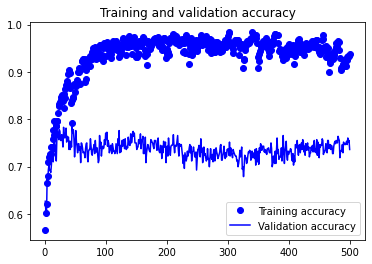

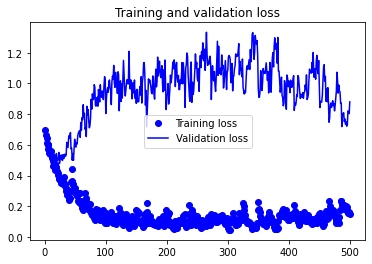

In [12]:
# Plot results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
models.save_model(CNN_model, CNN0_model_filename)

<font size="5">Fold Number 2</font>

In [8]:
# Compute indices for second fold

a = x_data[:598]
b = x_data[1196:2993]
x_data_temp = a + b
a = y_data[:598]
b = y_data[1196:2993]
y_data_temp = a + b
print(len(x_data_temp))
print(len(y_data_temp))

2395
2395


In [9]:
# Define second fold

batch_size = 64

training_data_batch = EEG_Mem_Generator(x_data_temp, y_data_temp, batch_size)
val_data_batch = EEG_Mem_Generator(x_data[598:1196], y_data[598:1196], batch_size)

In [10]:
# Define ChronoNet model

#del CNN_model
inputs = Input(shape=input_shape)
x = tf.transpose(inputs, perm = [0,2,1])


x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.GRU(32,return_sequences=True)(x)
x2 = tf.keras.layers.GRU(32,return_sequences=True)(x1)

x_con1 = tf.concat([x1,x2], axis = -1)

x3 = tf.keras.layers.GRU(32,return_sequences=True)(x_con1)

x_con2 = tf.concat([x1,x2,x3], axis = -1)

x = tf.keras.layers.GRU(32,return_sequences=False)(x_con2)

outputs = tf.keras.layers.Dense(units = 2,activation = 'softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model

CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
history = CNN_model.fit_generator(generator=training_data_batch,
                   steps_per_epoch = int(2395 // batch_size),
                   epochs = 500,
                   validation_data = val_data_batch,
                   validation_steps = int(598 // batch_size))
score = CNN_model.evaluate(training_data_batch, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(val_data_batch, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

models.save_model(CNN_model, CNN1_model_filename)

2022-04-25 09:18:00.234940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:18:00.272720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:18:00.272893: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 09:18:00.273476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "CNN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose (TFOpLam (None, 15000, 22)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 7500, 32)     2848        tf.compat.v1.transpose[0][0]     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7500, 32)     1440        tf.compat.v1.transpose[0][0]     
__________________________________________________________________________________________

/home/sebastian/anaconda3/envs/akida_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-25 09:18:03.165882: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 09:18:03.275229: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-04-25 09:18:06.723963: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 09:18:06.900635: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 09:18:10.378211: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8301
2022-04-25 09:18:13.133348: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-25 09:18:14.439838: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 2/37 [>.............................] - ETA: 13s - loss: 0.7783 - accuracy: 0.5000 

2022-04-25 09:18:19.463894: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.
2022-04-25 09:18:19.637460: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84480000 exceeds 10% of free system memory.


37/37 [==============================] - 34s 497ms/step - loss: 0.6978 - accuracy: 0.5500 - val_loss: 0.6726 - val_accuracy: 0.5781
Epoch 2/500
37/37 [==============================] - 9s 246ms/step - loss: 0.6574 - accuracy: 0.6010 - val_loss: 0.6763 - val_accuracy: 0.5938
Epoch 3/500
37/37 [==============================] - 9s 245ms/step - loss: 0.6340 - accuracy: 0.6495 - val_loss: 0.6603 - val_accuracy: 0.6215
Epoch 4/500
37/37 [==============================] - 9s 246ms/step - loss: 0.6332 - accuracy: 0.6504 - val_loss: 0.6353 - val_accuracy: 0.6545
Epoch 5/500
37/37 [==============================] - 9s 245ms/step - loss: 0.6039 - accuracy: 0.6770 - val_loss: 0.6618 - val_accuracy: 0.6267
Epoch 6/500
37/37 [==============================] - 9s 244ms/step - loss: 0.6004 - accuracy: 0.6924 - val_loss: 0.6802 - val_accuracy: 0.5764
Epoch 7/500
37/37 [==============================] - 9s 244ms/step - loss: 0.6024 - accuracy: 0.6714 - val_loss: 0.6441 - val_accuracy: 0.6302
Epoch 8/50

37/37 [==============================] - 9s 244ms/step - loss: 0.1800 - accuracy: 0.9254 - val_loss: 0.7667 - val_accuracy: 0.7378
Epoch 59/500
37/37 [==============================] - 9s 245ms/step - loss: 0.1596 - accuracy: 0.9382 - val_loss: 0.8148 - val_accuracy: 0.7344
Epoch 60/500
37/37 [==============================] - 9s 247ms/step - loss: 0.1576 - accuracy: 0.9442 - val_loss: 0.8533 - val_accuracy: 0.7500
Epoch 61/500
37/37 [==============================] - 9s 245ms/step - loss: 0.2126 - accuracy: 0.9112 - val_loss: 0.7678 - val_accuracy: 0.7396
Epoch 62/500
37/37 [==============================] - 9s 245ms/step - loss: 0.1777 - accuracy: 0.9258 - val_loss: 0.8743 - val_accuracy: 0.7240
Epoch 63/500
37/37 [==============================] - 9s 245ms/step - loss: 0.2053 - accuracy: 0.9228 - val_loss: 0.7246 - val_accuracy: 0.7500
Epoch 64/500
37/37 [==============================] - 9s 245ms/step - loss: 0.1900 - accuracy: 0.9309 - val_loss: 0.8089 - val_accuracy: 0.7135
Epoch

Epoch 115/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0674 - accuracy: 0.9730 - val_loss: 1.1735 - val_accuracy: 0.7413
Epoch 116/500
37/37 [==============================] - 9s 245ms/step - loss: 0.0552 - accuracy: 0.9790 - val_loss: 1.2225 - val_accuracy: 0.7205
Epoch 117/500
37/37 [==============================] - 9s 244ms/step - loss: 0.0919 - accuracy: 0.9644 - val_loss: 1.1858 - val_accuracy: 0.7361
Epoch 118/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1274 - accuracy: 0.9481 - val_loss: 1.0002 - val_accuracy: 0.7326
Epoch 119/500
37/37 [==============================] - 9s 245ms/step - loss: 0.0994 - accuracy: 0.9567 - val_loss: 0.9472 - val_accuracy: 0.7465
Epoch 120/500
37/37 [==============================] - 9s 244ms/step - loss: 0.0875 - accuracy: 0.9644 - val_loss: 1.0900 - val_accuracy: 0.7326
Epoch 121/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0982 - accuracy: 0.9627 - val_loss: 0.9171 - val_ac

37/37 [==============================] - 9s 243ms/step - loss: 0.1218 - accuracy: 0.9597 - val_loss: 0.9537 - val_accuracy: 0.7674
Epoch 228/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1302 - accuracy: 0.9494 - val_loss: 0.9563 - val_accuracy: 0.7465
Epoch 229/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1189 - accuracy: 0.9541 - val_loss: 1.0179 - val_accuracy: 0.7413
Epoch 230/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1147 - accuracy: 0.9545 - val_loss: 0.9066 - val_accuracy: 0.7691
Epoch 231/500
37/37 [==============================] - 9s 244ms/step - loss: 0.0909 - accuracy: 0.9653 - val_loss: 1.0033 - val_accuracy: 0.7483
Epoch 232/500
37/37 [==============================] - 9s 246ms/step - loss: 0.0826 - accuracy: 0.9671 - val_loss: 1.0148 - val_accuracy: 0.7396
Epoch 233/500
37/37 [==============================] - 9s 244ms/step - loss: 0.0886 - accuracy: 0.9661 - val_loss: 1.0519 - val_accuracy: 0.7344

37/37 [==============================] - 9s 242ms/step - loss: 0.0898 - accuracy: 0.9635 - val_loss: 1.0642 - val_accuracy: 0.7361
Epoch 340/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1004 - accuracy: 0.9588 - val_loss: 1.0408 - val_accuracy: 0.7222
Epoch 341/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1494 - accuracy: 0.9395 - val_loss: 1.2366 - val_accuracy: 0.6944
Epoch 342/500
37/37 [==============================] - 9s 245ms/step - loss: 0.2194 - accuracy: 0.9088 - val_loss: 0.8272 - val_accuracy: 0.7292
Epoch 343/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1620 - accuracy: 0.9361 - val_loss: 0.9083 - val_accuracy: 0.7396
Epoch 344/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1483 - accuracy: 0.9382 - val_loss: 0.8975 - val_accuracy: 0.7552
Epoch 345/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1378 - accuracy: 0.9399 - val_loss: 0.9900 - val_accuracy: 0.7274

37/37 [==============================] - 9s 247ms/step - loss: 0.0923 - accuracy: 0.9644 - val_loss: 1.0775 - val_accuracy: 0.7326
Epoch 452/500
37/37 [==============================] - 9s 250ms/step - loss: 0.0747 - accuracy: 0.9725 - val_loss: 1.0702 - val_accuracy: 0.7465
Epoch 453/500
37/37 [==============================] - 9s 253ms/step - loss: 0.0819 - accuracy: 0.9687 - val_loss: 1.1368 - val_accuracy: 0.7309
Epoch 454/500
37/37 [==============================] - 9s 249ms/step - loss: 0.0826 - accuracy: 0.9674 - val_loss: 0.9960 - val_accuracy: 0.7448
Epoch 455/500
37/37 [==============================] - 9s 248ms/step - loss: 0.1423 - accuracy: 0.9408 - val_loss: 1.0059 - val_accuracy: 0.7517
Epoch 456/500
37/37 [==============================] - 9s 250ms/step - loss: 0.1289 - accuracy: 0.9507 - val_loss: 1.0114 - val_accuracy: 0.7396
Epoch 457/500
37/37 [==============================] - 9s 248ms/step - loss: 0.1154 - accuracy: 0.9541 - val_loss: 0.9740 - val_accuracy: 0.7639

<font size="5">Fold Number 3</font>

In [11]:
# Compute the indices for the third fold

train1_index = np.arange(0,1196)
train2_index = np.arange(1794,2993)
print(len(train1_index))
print(len(train2_index))
train_index = np.concatenate((train1_index, train2_index))
print(len(train_index))

a = x_data[:1196]
b = x_data[1794:2993]
x_data_temp = a + b
a = y_data[:1196]
b = y_data[1794:2993]
y_data_temp = a + b
print(len(x_data_temp))
print(len(y_data_temp))

1196
1199
2395
2395
2395


In [12]:
# Define the data for the third fold

training_data_batch = EEG_Mem_Generator(x_data_temp, y_data_temp, batch_size)
val_data_batch = EEG_Mem_Generator(x_data[1196:1794], y_data[1196:1794], batch_size)

In [13]:
# Define the ChronoNet model

del CNN_model
inputs = Input(shape=input_shape)
x = tf.transpose(inputs, perm = [0,2,1])


x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.GRU(32,return_sequences=True)(x)
x2 = tf.keras.layers.GRU(32,return_sequences=True)(x1)

x_con1 = tf.concat([x1,x2], axis = -1)

x3 = tf.keras.layers.GRU(32,return_sequences=True)(x_con1)

x_con2 = tf.concat([x1,x2,x3], axis = -1)

x = tf.keras.layers.GRU(32,return_sequences=False)(x_con2)

outputs = tf.keras.layers.Dense(units = 2,activation = 'softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
history = CNN_model.fit_generator(generator=training_data_batch,
                   steps_per_epoch = int(2395 // batch_size),
                   epochs = 500,
                   validation_data = val_data_batch,
                   validation_steps = int(598 // batch_size))
score = CNN_model.evaluate(training_data_batch, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(val_data_batch, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

models.save_model(CNN_model, CNN2_model_filename)

Model: "CNN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_1 (TFOpL (None, 15000, 22)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 7500, 32)     2848        tf.compat.v1.transpose_1[0][0]   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 7500, 32)     1440        tf.compat.v1.transpose_1[0][0]   
__________________________________________________________________________________________

Epoch 76/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2909 - accuracy: 0.8734 - val_loss: 0.5394 - val_accuracy: 0.7708
Epoch 77/500
37/37 [==============================] - 9s 245ms/step - loss: 0.2944 - accuracy: 0.8717 - val_loss: 0.5179 - val_accuracy: 0.7726
Epoch 78/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2641 - accuracy: 0.8906 - val_loss: 0.5714 - val_accuracy: 0.7726
Epoch 79/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2390 - accuracy: 0.8996 - val_loss: 0.5849 - val_accuracy: 0.7552
Epoch 80/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2381 - accuracy: 0.9043 - val_loss: 0.5660 - val_accuracy: 0.7587
Epoch 81/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2388 - accuracy: 0.9018 - val_loss: 0.5716 - val_accuracy: 0.7622
Epoch 82/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2262 - accuracy: 0.9103 - val_loss: 0.6049 - val_accuracy:

37/37 [==============================] - 9s 243ms/step - loss: 0.0889 - accuracy: 0.9648 - val_loss: 0.9452 - val_accuracy: 0.7517
Epoch 189/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0726 - accuracy: 0.9730 - val_loss: 1.0119 - val_accuracy: 0.7535
Epoch 190/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0728 - accuracy: 0.9713 - val_loss: 0.9273 - val_accuracy: 0.7778
Epoch 191/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1023 - accuracy: 0.9597 - val_loss: 0.9244 - val_accuracy: 0.7500
Epoch 192/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1283 - accuracy: 0.9481 - val_loss: 0.9054 - val_accuracy: 0.7639
Epoch 193/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1527 - accuracy: 0.9361 - val_loss: 0.8984 - val_accuracy: 0.7344
Epoch 194/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1198 - accuracy: 0.9571 - val_loss: 0.8599 - val_accuracy: 0.7726

37/37 [==============================] - 9s 245ms/step - loss: 0.0996 - accuracy: 0.9622 - val_loss: 0.8977 - val_accuracy: 0.7639
Epoch 301/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1355 - accuracy: 0.9459 - val_loss: 0.9257 - val_accuracy: 0.7691
Epoch 302/500
37/37 [==============================] - 9s 246ms/step - loss: 0.1928 - accuracy: 0.9219 - val_loss: 0.8605 - val_accuracy: 0.7413
Epoch 303/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1896 - accuracy: 0.9314 - val_loss: 0.8472 - val_accuracy: 0.7344
Epoch 304/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1626 - accuracy: 0.9352 - val_loss: 0.7554 - val_accuracy: 0.7604
Epoch 305/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1242 - accuracy: 0.9507 - val_loss: 0.8160 - val_accuracy: 0.7517
Epoch 306/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1012 - accuracy: 0.9588 - val_loss: 0.8759 - val_accuracy: 0.7587

37/37 [==============================] - 9s 243ms/step - loss: 0.2352 - accuracy: 0.9009 - val_loss: 0.7246 - val_accuracy: 0.7483
Epoch 413/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2378 - accuracy: 0.8966 - val_loss: 0.6583 - val_accuracy: 0.7656
Epoch 414/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2042 - accuracy: 0.9193 - val_loss: 0.7759 - val_accuracy: 0.7448
Epoch 415/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1697 - accuracy: 0.9335 - val_loss: 0.7982 - val_accuracy: 0.7396
Epoch 416/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1616 - accuracy: 0.9387 - val_loss: 0.7314 - val_accuracy: 0.7622
Epoch 417/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1659 - accuracy: 0.9309 - val_loss: 0.7472 - val_accuracy: 0.7517
Epoch 418/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2117 - accuracy: 0.9146 - val_loss: 0.7973 - val_accuracy: 0.7413

<font size="5">Fold Number 4</font>

In [14]:
# Define the indices for the fourth fold

a = x_data[:1794]
b = x_data[2392:2993]
x_data_temp = a + b
a = y_data[:1794]
b = y_data[2392:2993]
y_data_temp = a + b
print(len(x_data_temp))
print(len(y_data_temp))

2395
2395


In [15]:
# Define the data for the fourth fold 

training_data_batch = EEG_Mem_Generator(x_data_temp, y_data_temp, batch_size)
val_data_batch = EEG_Mem_Generator(x_data[1794:2392], y_data[1794:2392], batch_size)

In [16]:
# Define the ChronoNet model

del CNN_model
inputs = Input(shape=input_shape)
x = tf.transpose(inputs, perm = [0,2,1])


x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.GRU(32,return_sequences=True)(x)
x2 = tf.keras.layers.GRU(32,return_sequences=True)(x1)

x_con1 = tf.concat([x1,x2], axis = -1)

x3 = tf.keras.layers.GRU(32,return_sequences=True)(x_con1)

x_con2 = tf.concat([x1,x2,x3], axis = -1)

x = tf.keras.layers.GRU(32,return_sequences=False)(x_con2)

outputs = tf.keras.layers.Dense(units = 2,activation = 'softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model
CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
history = CNN_model.fit_generator(generator=training_data_batch,
                   steps_per_epoch = int(2395 // batch_size),
                   epochs = 500,
                   validation_data = val_data_batch,
                   validation_steps = int(598 // batch_size))
score = CNN_model.evaluate(training_data_batch, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(val_data_batch, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

models.save_model(CNN_model, CNN3_model_filename)

Model: "CNN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_2 (TFOpL (None, 15000, 22)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 7500, 32)     2848        tf.compat.v1.transpose_2[0][0]   
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 7500, 32)     1440        tf.compat.v1.transpose_2[0][0]   
__________________________________________________________________________________________

Epoch 76/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3671 - accuracy: 0.8318 - val_loss: 0.4332 - val_accuracy: 0.7865
Epoch 77/500
37/37 [==============================] - 9s 243ms/step - loss: 0.3333 - accuracy: 0.8589 - val_loss: 0.4415 - val_accuracy: 0.8090
Epoch 78/500
37/37 [==============================] - 9s 243ms/step - loss: 0.3218 - accuracy: 0.8606 - val_loss: 0.4878 - val_accuracy: 0.7917
Epoch 79/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2988 - accuracy: 0.8704 - val_loss: 0.4503 - val_accuracy: 0.8125
Epoch 80/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2949 - accuracy: 0.8747 - val_loss: 0.4886 - val_accuracy: 0.7882
Epoch 81/500
37/37 [==============================] - 9s 243ms/step - loss: 0.3082 - accuracy: 0.8704 - val_loss: 0.4582 - val_accuracy: 0.7969
Epoch 82/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2765 - accuracy: 0.8906 - val_loss: 0.5339 - val_accuracy:

37/37 [==============================] - 9s 244ms/step - loss: 0.0793 - accuracy: 0.9730 - val_loss: 0.8031 - val_accuracy: 0.7986
Epoch 189/500
37/37 [==============================] - 9s 245ms/step - loss: 0.0973 - accuracy: 0.9657 - val_loss: 0.7408 - val_accuracy: 0.7899
Epoch 190/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1158 - accuracy: 0.9580 - val_loss: 0.7699 - val_accuracy: 0.7847
Epoch 191/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1062 - accuracy: 0.9580 - val_loss: 0.8103 - val_accuracy: 0.7812
Epoch 192/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1528 - accuracy: 0.9434 - val_loss: 0.8781 - val_accuracy: 0.7656
Epoch 193/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1722 - accuracy: 0.9309 - val_loss: 0.6746 - val_accuracy: 0.7917
Epoch 194/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1239 - accuracy: 0.9562 - val_loss: 0.6881 - val_accuracy: 0.7917

37/37 [==============================] - 9s 244ms/step - loss: 0.1174 - accuracy: 0.9550 - val_loss: 0.8828 - val_accuracy: 0.7917
Epoch 301/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1003 - accuracy: 0.9618 - val_loss: 0.8248 - val_accuracy: 0.7812
Epoch 302/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1001 - accuracy: 0.9601 - val_loss: 0.8650 - val_accuracy: 0.7743
Epoch 303/500
37/37 [==============================] - 9s 245ms/step - loss: 0.1241 - accuracy: 0.9558 - val_loss: 0.8099 - val_accuracy: 0.7865
Epoch 304/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1235 - accuracy: 0.9494 - val_loss: 0.8119 - val_accuracy: 0.7778
Epoch 305/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1249 - accuracy: 0.9494 - val_loss: 0.7970 - val_accuracy: 0.7691
Epoch 306/500
37/37 [==============================] - 9s 244ms/step - loss: 0.1145 - accuracy: 0.9550 - val_loss: 0.8168 - val_accuracy: 0.7812

37/37 [==============================] - 9s 243ms/step - loss: 0.3432 - accuracy: 0.8417 - val_loss: 0.5254 - val_accuracy: 0.7569
Epoch 413/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3478 - accuracy: 0.8456 - val_loss: 0.5129 - val_accuracy: 0.7847
Epoch 414/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3187 - accuracy: 0.8550 - val_loss: 0.5131 - val_accuracy: 0.7743
Epoch 415/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3114 - accuracy: 0.8657 - val_loss: 0.5407 - val_accuracy: 0.7691
Epoch 416/500
37/37 [==============================] - 9s 243ms/step - loss: 0.3011 - accuracy: 0.8687 - val_loss: 0.5152 - val_accuracy: 0.7674
Epoch 417/500
37/37 [==============================] - 9s 244ms/step - loss: 0.2724 - accuracy: 0.8803 - val_loss: 0.5285 - val_accuracy: 0.8021
Epoch 418/500
37/37 [==============================] - 9s 243ms/step - loss: 0.2906 - accuracy: 0.8739 - val_loss: 0.5122 - val_accuracy: 0.7986

<font size="5">Fold Number 5</font>

In [17]:
# Define the data for the fifth fold

training_data_batch = EEG_Mem_Generator(x_data[:2393], y_data[:2393], batch_size)
val_data_batch = EEG_Mem_Generator(x_data[2395:2993], y_data[2395:2993], batch_size)

In [18]:
# Define the ChronoNet model

del CNN_model
inputs = Input(shape=input_shape)
x = tf.transpose(inputs, perm = [0,2,1])


x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.Conv1D(32, 4, strides = 2, activation='elu',padding = 'same')(x)
x2 = tf.keras.layers.Conv1D(32, 2, strides = 2, activation='elu',padding = 'same')(x)
x3 = tf.keras.layers.Conv1D(32, 8, strides = 2, activation='elu',padding = 'same')(x)

x = tf.concat([x1,x2,x3], axis = -1)

x1 = tf.keras.layers.GRU(32,return_sequences=True)(x)
x2 = tf.keras.layers.GRU(32,return_sequences=True)(x1)

x_con1 = tf.concat([x1,x2], axis = -1)

x3 = tf.keras.layers.GRU(32,return_sequences=True)(x_con1)

x_con2 = tf.concat([x1,x2,x3], axis = -1)

x = tf.keras.layers.GRU(32,return_sequences=False)(x_con2)

outputs = tf.keras.layers.Dense(units = 2,activation = 'softmax')(x)

CNN_model = keras.Model(inputs=inputs, outputs=outputs, name='CNN_model')
CNN_model.summary()

# Compile the model

CNN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, nesterov = True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
history = CNN_model.fit_generator(generator=training_data_batch,
                   steps_per_epoch = int(2395 // batch_size),
                   epochs = 500,
                   validation_data = val_data_batch,
                   validation_steps = int(598 // batch_size))
score = CNN_model.evaluate(training_data_batch, verbose=0)
print('Accuracy on train set of CNN:', score[1] * 100,'%')
score = CNN_model.evaluate(val_data_batch, verbose=0)
print('Accuracy on validation set of CNN:', score[1] * 100,'%')

models.save_model(CNN_model, CNN4_model_filename)

Model: "CNN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 22, 15000)]  0                                            
__________________________________________________________________________________________________
tf.compat.v1.transpose_3 (TFOpL (None, 15000, 22)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 7500, 32)     2848        tf.compat.v1.transpose_3[0][0]   
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 7500, 32)     1440        tf.compat.v1.transpose_3[0][0]   
__________________________________________________________________________________________

Epoch 76/500
37/37 [==============================] - 9s 242ms/step - loss: 0.2580 - accuracy: 0.8952 - val_loss: 0.6073 - val_accuracy: 0.7465
Epoch 77/500
37/37 [==============================] - 10s 264ms/step - loss: 0.2725 - accuracy: 0.8845 - val_loss: 0.5980 - val_accuracy: 0.7378
Epoch 78/500
37/37 [==============================] - 9s 243ms/step - loss: 0.3155 - accuracy: 0.8622 - val_loss: 0.5541 - val_accuracy: 0.7396
Epoch 79/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3779 - accuracy: 0.8227 - val_loss: 0.5594 - val_accuracy: 0.7431
Epoch 80/500
37/37 [==============================] - 9s 245ms/step - loss: 0.3511 - accuracy: 0.8459 - val_loss: 0.5636 - val_accuracy: 0.7604
Epoch 81/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3397 - accuracy: 0.8489 - val_loss: 0.6412 - val_accuracy: 0.7101
Epoch 82/500
37/37 [==============================] - 9s 244ms/step - loss: 0.3259 - accuracy: 0.8510 - val_loss: 0.6306 - val_accuracy

37/37 [==============================] - 9s 243ms/step - loss: 0.0909 - accuracy: 0.9657 - val_loss: 0.9647 - val_accuracy: 0.7552
Epoch 189/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1340 - accuracy: 0.9485 - val_loss: 0.9238 - val_accuracy: 0.7691
Epoch 190/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1436 - accuracy: 0.9463 - val_loss: 0.9426 - val_accuracy: 0.7396
Epoch 191/500
37/37 [==============================] - 9s 242ms/step - loss: 0.2166 - accuracy: 0.9141 - val_loss: 0.7923 - val_accuracy: 0.7309
Epoch 192/500
37/37 [==============================] - 9s 242ms/step - loss: 0.1816 - accuracy: 0.9274 - val_loss: 0.8358 - val_accuracy: 0.7448
Epoch 193/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1605 - accuracy: 0.9347 - val_loss: 0.7987 - val_accuracy: 0.7569
Epoch 194/500
37/37 [==============================] - 9s 243ms/step - loss: 0.1452 - accuracy: 0.9455 - val_loss: 0.7514 - val_accuracy: 0.7691

37/37 [==============================] - 9s 244ms/step - loss: 0.0614 - accuracy: 0.9798 - val_loss: 1.1018 - val_accuracy: 0.7535
Epoch 301/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0805 - accuracy: 0.9699 - val_loss: 1.2040 - val_accuracy: 0.7378
Epoch 302/500
37/37 [==============================] - 9s 242ms/step - loss: 0.0914 - accuracy: 0.9665 - val_loss: 1.1116 - val_accuracy: 0.7309
Epoch 303/500
37/37 [==============================] - 9s 243ms/step - loss: 0.0813 - accuracy: 0.9682 - val_loss: 1.1096 - val_accuracy: 0.7326
Epoch 304/500
37/37 [==============================] - 9s 244ms/step - loss: 0.0670 - accuracy: 0.9760 - val_loss: 1.1475 - val_accuracy: 0.7465
Epoch 305/500
37/37 [==============================] - 9s 245ms/step - loss: 0.0896 - accuracy: 0.9678 - val_loss: 1.0562 - val_accuracy: 0.7448
Epoch 306/500
37/37 [==============================] - 9s 246ms/step - loss: 0.1155 - accuracy: 0.9584 - val_loss: 1.0959 - val_accuracy: 0.7309

37/37 [==============================] - 9s 246ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 1.2795 - val_accuracy: 0.7309
Epoch 413/500
37/37 [==============================] - 9s 247ms/step - loss: 0.0582 - accuracy: 0.9781 - val_loss: 1.2872 - val_accuracy: 0.7170
Epoch 414/500
37/37 [==============================] - 9s 247ms/step - loss: 0.0827 - accuracy: 0.9652 - val_loss: 1.1983 - val_accuracy: 0.7309
Epoch 415/500
37/37 [==============================] - 9s 247ms/step - loss: 0.0625 - accuracy: 0.9742 - val_loss: 1.2939 - val_accuracy: 0.7326
Epoch 416/500
37/37 [==============================] - 9s 246ms/step - loss: 0.0776 - accuracy: 0.9665 - val_loss: 1.1497 - val_accuracy: 0.7344
Epoch 417/500
37/37 [==============================] - 9s 246ms/step - loss: 0.0762 - accuracy: 0.9674 - val_loss: 1.1456 - val_accuracy: 0.7292
Epoch 418/500
37/37 [==============================] - 9s 246ms/step - loss: 0.0833 - accuracy: 0.9678 - val_loss: 1.1895 - val_accuracy: 0.7274